In [40]:
import numpy as np
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, cross_val_score

In [41]:
# reading data files and storing them in a dataframe
df_train_features = pd.read_csv('D:/Fundamental of AI/lish-moa/train_features.csv')
df_test_features = pd.read_csv('D:/Fundamental of AI/lish-moa/test_features.csv')
df_train_target_nonscored = pd.read_csv('D:/Fundamental of AI/lish-moa/train_targets_nonscored.csv')
df_train_target_scored = pd.read_csv('D:/Fundamental of AI/lish-moa/train_targets_scored.csv')

In [42]:
# Feature Extraction 
ctl_vehicle_ids = (df_train_features['cp_type'] == 'ctl_vehicle')
cp_cat_cols = ['cp_type', 'cp_time', 'cp_dose']
# select all indices when 'cp_type' is 'ctl_vehicle'
ctl_vehicle_cols = (df_train_features['cp_type'] == 'ctl_vehicle')
# take a copy of all our training sig_ids for reference
train_sig_ids = df_train_features['sig_id'].copy()
# drop cp_type column since we no longer need it
X = df_train_features.drop(['sig_id', 'cp_type'], axis=1).copy()
X = X.loc[~ctl_vehicle_ids].copy()
y = df_train_target_scored.drop('sig_id', axis=1).copy()
y = y.loc[~ctl_vehicle_ids].copy()

In [43]:
# Data pre processing
class data_pre_processor(BaseEstimator, TransformerMixin):
   # data prep processing and data loading into the function
    def __init__(self, remove_ctl_vehicles=True, std_features=True, encode_cat=True,
                 cp_cat_cols=['cp_time', 'cp_dose']):
        self.remove_ctl_vehicles = remove_ctl_vehicles
        self.std_features = std_features
        self.cp_cat_cols = cp_cat_cols
        self.encode_cat = encode_cat 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        temp_df = self._remove_features(X).copy()
        if self.std_features:
            pass
        if self.encode_cat:
            temp_df = pd.concat([pd.get_dummies(temp_df.cp_dose, prefix='cp_dose'), 
                                temp_df.drop('cp_dose', axis=1)], axis=1)
            temp_df = pd.concat([pd.get_dummies(temp_df.cp_time, prefix='cp_time'),
                                temp_df.drop('cp_time', axis=1)], axis=1)
            
        return temp_df
    def _remove_features(self, dataframe):
        if self.remove_ctl_vehicles:
            temp_df = dataframe.drop(['sig_id', 'cp_type'], axis=1) 
        else:
            temp_df = dataframe.drop('sig_id', axis=1)
        return temp_df
    def _standardise_features(self, dataframe):
        pass
        

In [44]:
# features extraction continued
train_sig_ids = df_train_features['sig_id'].copy()
# select all indices when 'cp_type' is 'ctl_vehicle'
train_ctl_vehicle_ids = (df_train_features['cp_type'] == 'ctl_vehicle')
# initialization of data processing class for transforming dataset
data_pre_processor = data_pre_processor()
# dropping low correlated features and which are not required and encode  of categorical features from feature and target variables
X = data_pre_processor.fit_transform(df_train_features)
y = df_train_target_scored.drop('sig_id', axis=1).copy()
# dropping the rows where cp_type is ctl_vehicle from training features  and target sets
X = X.loc[~train_ctl_vehicle_ids].copy()
y = df_train_target_scored.drop('sig_id', axis=1).copy()
y = y.loc[~train_ctl_vehicle_ids].copy()
# standardisation of numerical columns
std_scaler = StandardScaler()
num_cols = [x for x in X.columns.values if not x.startswith(('cp_time', 'cp_dose'))]
X_std = X.copy()
X_std[num_cols] = std_scaler.fit_transform(X.loc[:, num_cols])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [45]:
# Model Building, loss calcuation and prediction of values
lin_reg = LinearRegression()
lin_reg = LinearRegression()
lr_val_preds = cross_val_predict(lin_reg, X_std, y, cv=5)
lr_log_loss = log_loss(np.ravel(y), np.ravel(lr_val_preds))
print(f"Log loss for Linear Regression Model: {lr_log_loss:.5f}\n")


Log loss for Linear Regression Model: 0.03581



In [46]:
# principle component analysis and calculating loss for each iteration
n_range = [1, 2, 5, 10, 25, 50, 100, 150, 200, 250]
log_losses = []

lin_reg = LinearRegression()

for n in n_range:
    pca = PCA(n_components=n)
    lr_model = Pipeline(steps=[('pca', pca), ('linear regression', lin_reg)])
    
    # evaluate of model using cross validation
    lr_val_preds = cross_val_predict(lr_model, X_std, y, cv=5)

    #  we need to flatten both arrays before computing log loss
    lr_log_loss = log_loss(np.ravel(y), np.ravel(lr_val_preds))
    print(f"Log loss for Linear Regression with PCA (n={n}): {lr_log_loss:.5f}\n")
    
    log_losses.append(lr_log_loss)


Log loss for Linear Regression with PCA (n=1): 0.02145

Log loss for Linear Regression with PCA (n=2): 0.02154

Log loss for Linear Regression with PCA (n=5): 0.02134

Log loss for Linear Regression with PCA (n=10): 0.02149

Log loss for Linear Regression with PCA (n=25): 0.02193

Log loss for Linear Regression with PCA (n=50): 0.02251

Log loss for Linear Regression with PCA (n=100): 0.02489

Log loss for Linear Regression with PCA (n=150): 0.02703

Log loss for Linear Regression with PCA (n=200): 0.02802

Log loss for Linear Regression with PCA (n=250): 0.02960



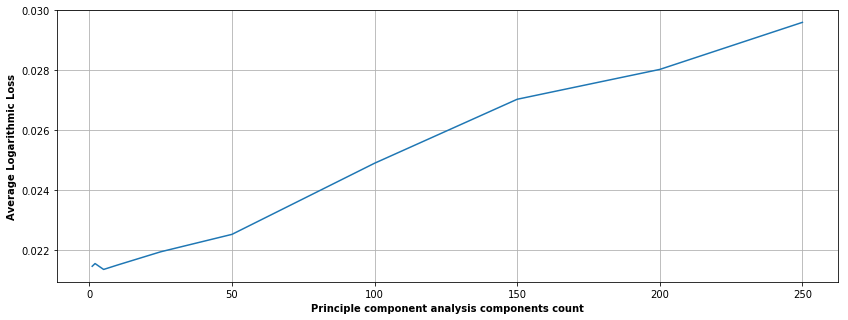

In [47]:
# Performance of model visualization using seaborn library
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
sns.lineplot(x=n_range, y=log_losses)
plt.ylabel("Average Logarithmic Loss", weight='bold')
plt.xlabel("Principle component analysis components count", weight='bold')
plt.grid()
plt.show()

In [48]:
# using model to make predictions on test data set
# filtering sig ids for splitting feature and target variables
test_sig_ids = df_test_features['sig_id'].copy()
# filtering the rows in test dataset where 'cp_type' is 'ctl_vehicle'
test_dataset_ctl_vehicle_ids = (df_test_features['cp_type'] == 'ctl_vehicle')
X_test = data_pre_processor.transform(df_test_features)
# Sclaing of test dataset
test_cols = [x for x in X_test.columns.values if not x.startswith(('cp_time', 'cp_dose'))]
X_test_standardization = X_test.copy()
X_test_standardization[test_cols] = std_scaler.transform(X_test.loc[:, test_cols])
# fitting model on test dataset
lin_reg = LinearRegression()
pca = PCA(n_components=5)
lr_model = Pipeline(steps=[('pca', pca), ('linear regression', lin_reg)])
%time lr_model.fit(X_std, y)
#  final predicted values on test dataset
test_prediction = lr_model.predict(X_test_standardization)
test_prediction[test_sig_ids[test_dataset_ctl_vehicle_ids].index.values]

Wall time: 2.04 s


array([[0.00046377, 0.0006407 , 0.00114837, ..., 0.00122346, 0.00272145,
        0.00180142],
       [0.00065271, 0.00099882, 0.00137201, ..., 0.00159442, 0.00226174,
        0.00179955],
       [0.00043257, 0.00033788, 0.00112418, ..., 0.00112083, 0.00297463,
        0.00171873],
       ...,
       [0.00102035, 0.00079012, 0.00124033, ..., 0.00142104, 0.002519  ,
        0.00173592],
       [0.00152803, 0.00075749, 0.00133695, ..., 0.00149892, 0.00184438,
        0.00126538],
       [0.00074455, 0.00069628, 0.00135145, ..., 0.00155215, 0.00275985,
        0.00184625]])

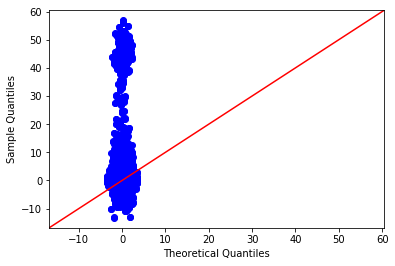

In [49]:
#plotting qq plot
import statsmodels.api as sm
sm.qqplot(test_prediction,fit=True,line='45')
plt.show()

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from datetime import date
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [67]:
# random seed value
xseed = 43

# number of folds for cv
nfolds = 5

# number of components from PCA decomposition
nof_comp = 250

model_name = 'lr'

X_train = pd.read_csv('D:/Fundamental of AI/lish-moa/train_features.csv')
X_test = pd.read_csv('D:/Fundamental of AI/lish-moa/test_features.csv')
y_train = pd.read_csv('D:/Fundamental of AI/lish-moa/train_targets_scored.csv')


In [68]:
# data pre processing

print(set(X_train['cp_time']), set(X_test['cp_time']) )

# cp_time processing
X_train['cp_time_24'] = (X_train['cp_time'] == 24) + 0
X_train['cp_time_48'] = (X_train['cp_time'] == 48) + 0
X_test['cp_time_24'] = (X_test['cp_time'] == 24) + 0
X_test['cp_time_48'] = (X_test['cp_time'] == 48) + 0
X_train.drop('cp_time', axis = 1, inplace = True)
X_test.drop('cp_time', axis = 1, inplace = True)

# cp_dose processing
print(set(X_train['cp_dose']), set(X_test['cp_dose']) )
X_train['cp_dose_D1'] = (X_train['cp_dose'] == 'D1') + 0
X_test['cp_dose_D1'] = (X_test['cp_dose'] == 'D1') + 0
X_train.drop('cp_dose', axis = 1, inplace = True)
X_test.drop('cp_dose', axis = 1, inplace = True)
# cp_type processing
X_train['cp_type_control'] = (X_train['cp_type'] == 'ctl_vehicle') + 0
X_test['cp_type_control'] = (X_test['cp_type'] == 'ctl_vehicle') + 0
X_train.drop('cp_type', axis = 1, inplace = True)
X_test.drop('cp_type', axis = 1, inplace = True)

{24, 48, 72} {24, 48, 72}
{'D2', 'D1'} {'D2', 'D1'}


In [69]:
# prepare split for the k fold
kf = KFold(n_splits = nfolds)

# separation of train and test
id_train = X_train['sig_id']
id_test = X_test['sig_id']
y_train.drop('sig_id', axis = 1, inplace = True) 
X_train.drop('sig_id', axis = 1, inplace = True)
X_test.drop('sig_id', axis = 1, inplace = True)

# storage matrices for test predictions
prval = np.zeros(y_train.shape)
prfull = np.zeros((X_test.shape[0], y_train.shape[1]))

In [70]:
# base model defining
pca = PCA(n_components = nof_comp)
logistic = LogisticRegression(max_iter=10000, tol=0.1, C = 0.5)
base_model = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# a pipeline can be fed into MultiOutputClassifier just like a regular estimator would
mo_base = MultiOutputClassifier(base_model, n_jobs=-1)

In [72]:
for (ff, (id0, id1)) in enumerate(kf.split(X_train)):
     
    x0, x1 = X_train.loc[id0], X_train.loc[id1]
    y0, y1 = np.array(y_train.loc[id0]), np.array(y_train.loc[id1])
    check_for_empty_cols = np.where(y0.sum(axis = 0) == 0)[0]
    if len(check_for_empty_cols):
        y0[0,check_for_empty_cols] = 1
    
    # fit model
    mo_base.fit(x0,y0)
    
    # generate the prediction
    vpred = mo_base.predict_proba(x1)
    fpred = mo_base.predict_proba(X_test)
    
    for ii in range(0,y_train.shape[1]):
        
        prval[id1,ii] = vpred[ii][:,1]
        prfull[:,ii] += fpred[ii][:,1]/nfolds

In [ ]:
prval = pd.DataFrame(prval); prval.columns = y_train.columns
prval['sig_id'] = id_train

prfull = pd.DataFrame(prfull); prfull.columns = y_train.columns
prfull['sig_id'] = id_test

In [ ]:
metrics = []
for _target in y_train.columns:
    metrics.append(log_loss(y_train.loc[:, _target], prval.loc[:, _target]))
print(f'OOF Metric: {np.round(np.mean(metrics),4)}')

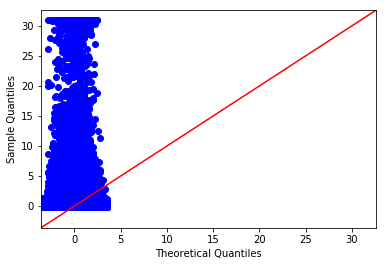

In [74]:
#plotting qq plot for logistic
import statsmodels.api as sm
sm.qqplot(prfull,fit=True,line='45')
plt.show()